In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.2 MB/s eta 0:00:00


In [5]:
import  sys
sys.path.append("..")
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
# For data manipulation
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm

# Import adfuller
from statsmodels.tsa.stattools import adfuller

# For statistical analysis
from statsmodels.tsa.arima.model import ARIMA

#for price data
import yfinance as yf
import pandas_datareader.data as web



In [6]:
# Define the symbol, start, and end dates for the Nifty index
symbol = '^NSEI'
start = '2019-01-01'
end = '2023-12-31'

# Download weekly closing price data for Nifty from Yahoo Finance
data = yf.download(symbol, start=start, end=end, interval='1d')[['Adj Close']]
# Display the first few rows of the data
print(data.head())


[*********************100%***********************]  1 of 1 completed

               Adj Close
Date                    
2019-01-02  10792.500000
2019-01-03  10672.250000
2019-01-04  10727.349609
2019-01-07  10771.799805
2019-01-08  10802.150391


In [8]:
import pandas as pd

def sanity_check(data):
  if data.isnull().values.any():
     print("Missing values found.")
     data.fillna(method='ffill', inplace=True)
     print("Missing values have been forward-filled.")
  else:
     print("No missing values in the data.")
  return data
data = sanity_check(data)

# Check for invalid/NaN data
print(data.isnull().sum())


No missing values in the data.
Adj Close    0
dtype: int64


In [9]:
def check_stationarity(df):
  adf_result = adfuller(df)

  if(adf_result[1] < 0.05):
    print('Data is stationary')
  else:
    print('Data is not stationary')

# Checking the Adj Close for stationarity
check_stationarity(data['Adj Close'])


Data is not stationary


In [10]:
# Check the differenced asset 1 for stationarity
check_stationarity(data['Adj Close'].diff().dropna())


Data is stationary


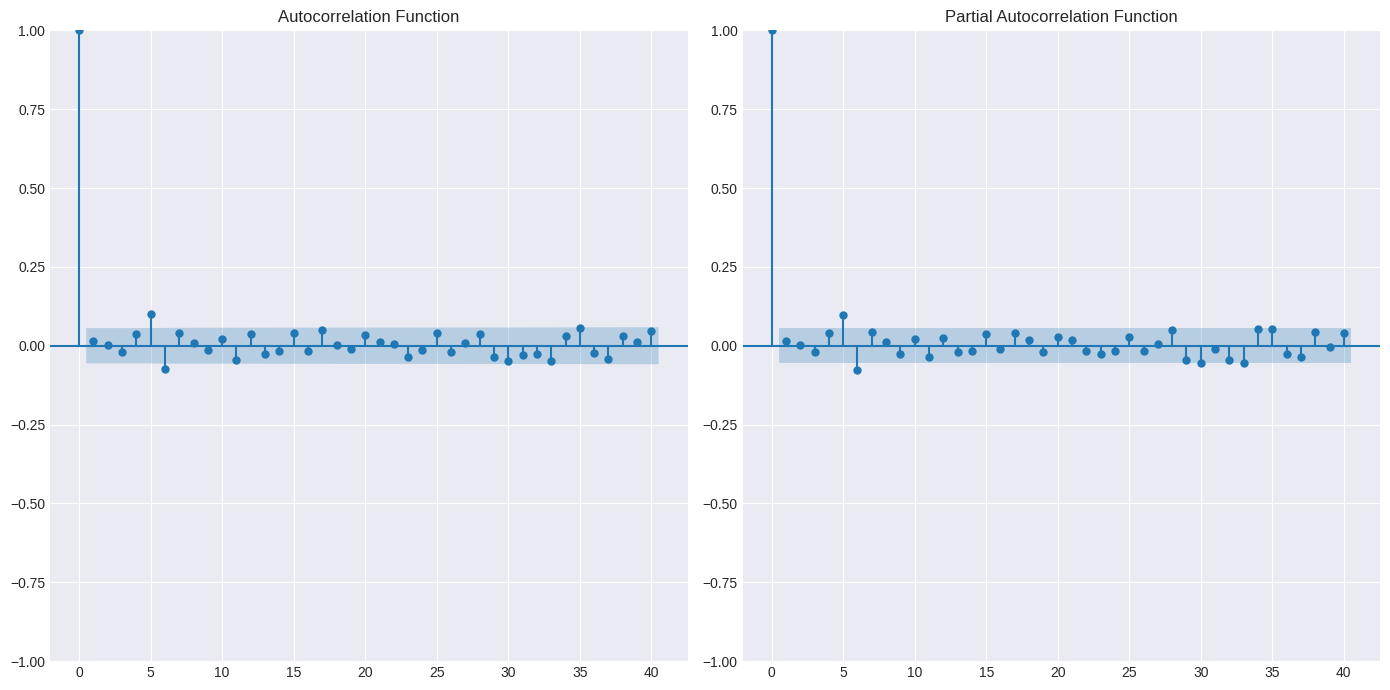

In [11]:
# Importing neccessary module from statsmodels library
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# To accurately map the acf and pacf, we need a stationary series
diff_data = data['Adj Close'].diff().dropna()

# Plotting ACF
plt.figure(figsize=(14, 7))
plt.subplot(121) # 1 row, 2 columns, 1st subplot
plot_acf(diff_data, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')
# Plotting PACF
plt.subplot(122) # 1 row, 2 columns, 2nd subplot
plot_pacf(diff_data, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


In [12]:
# Splitting the data into train and test that we can use the test data to evaluate our chosen model
split = int(len(data)*0.8)
data_train = data[:split]
data_test = data[split:]
print(data_train.shape[0], data_test.shape[0])

985 247


In [13]:
print(data_test.tail())

               Adj Close
Date                    
2023-12-22  21349.400391
2023-12-26  21441.349609
2023-12-27  21654.750000
2023-12-28  21778.699219
2023-12-29  21731.400391


In [15]:
import warnings
import pmdarima as pm

def find_best_arima_parameters(data_series, seasonal=False, m=1):

  # Ignoring warnings
  warnings.filterwarnings('ignore')

# Performing the auto ARIMA process
  model = pm.auto_arima(data_series, seasonal=seasonal, m=m,trace=True, error_action='ignore',suppress_warnings=True)

# Extracting the best ARIMA order
  best_order = model.order # This gives (p, d, q)

# Optionally, print the summary of the best model
  print(model.summary())

  return best_order



In [16]:
# Assuming 'data' is your DataFrame and 'Adj Close' is a column in that DataFrame
best_param = find_best_arima_parameters(data_train['Adj Close'])
print("Best ARIMA parameters (p, d, q):", best_param)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12800.571, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12805.026, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12806.984, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12806.989, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12805.113, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12810.971, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12810.981, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12798.938, Time=0.85 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12812.400, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=12809.377, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12803.398, Time=1.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12799.054, Time=1.05 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12809.237, Time=0.64 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=12802.879, Time=1.54 sec
 ARIMA(3,1,2)(0,0,0

In [17]:
def get_predicted_prices(close_prices, best_param):


# Defining the best model
  best_model = ARIMA(close_prices.values, order=best_param)
  best_model_fit = best_model.fit(method_kwargs={"warn_convergence":False})

# Making forecast
  predictions = best_model_fit.forecast(steps=1)[0]
  return predictions


In [18]:
# Assuming best_param has already been determined using the training data
predictions = []
for i in range(len(data_test['Adj Close'])):
  current_data = pd.concat([data_train['Adj Close'], data_test['Adj Close'].iloc[:i]])
  next_pred = get_predicted_prices(current_data, best_param)
  predictions.append(next_pred)

# Converting the predictions list to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['predicted_price'])
predictions_df.index = data_test.index
print(predictions_df)


            predicted_price
Date                       
2022-12-29     18153.151001
2022-12-30     18184.190577
2023-01-02     18081.177003
2023-01-03     18215.679646
2023-01-04     18248.846660
...                     ...
2023-12-22     21241.906965
2023-12-26     21342.590258
2023-12-27     21461.555537
2023-12-28     21654.462881
2023-12-29     21766.473924

[247 rows x 1 columns]


In [25]:
data_test = pd.concat([data_test, predictions_df], axis=1)
print(data_test)

               Adj Close  predicted_price
Date                                     
2022-12-29  18191.000000     18153.151001
2022-12-30  18105.300781     18184.190577
2023-01-02  18197.449219     18081.177003
2023-01-03  18232.550781     18215.679646
2023-01-04  18042.949219     18248.846660
...                  ...              ...
2023-12-22  21349.400391     21241.906965
2023-12-26  21441.349609     21342.590258
2023-12-27  21654.750000     21461.555537
2023-12-28  21778.699219     21654.462881
2023-12-29  21731.400391     21766.473924

[247 rows x 2 columns]


In [26]:
data_test['predicted_returns'] = data_test['predicted_price'].pct_change()
data_test['actual_returns'] = data_test['Adj Close'].pct_change()
data_test.dropna(inplace=True)

#signal generation
data_test['signal'] = np.where(data_test['predicted_returns'] >=0, 1,
-1)

#we may approach differently here and assume that we have learnt the predicted prices in advance and will be able to position ourselves
data_test['strategy_returns'] = data_test['signal'] * data_test['actual_returns']
data_test['cumulative_returns'] = np.cumprod(data_test['strategy_returns']+1)
print(data_test)


               Adj Close  predicted_price  predicted_returns  actual_returns  \
Date                                                                           
2022-12-30  18105.300781     18184.190577           0.001710       -0.004711   
2023-01-02  18197.449219     18081.177003          -0.005665        0.005090   
2023-01-03  18232.550781     18215.679646           0.007439        0.001929   
2023-01-04  18042.949219     18248.846660           0.001821       -0.010399   
2023-01-05  17992.150391     18012.626791          -0.012944       -0.002815   
...                  ...              ...                ...             ...   
2023-12-22  21349.400391     21241.906965           0.003219        0.004439   
2023-12-26  21441.349609     21342.590258           0.004740        0.004307   
2023-12-27  21654.750000     21461.555537           0.005574        0.009953   
2023-12-28  21778.699219     21654.462881           0.008989        0.005724   
2023-12-29  21731.400391     21766.47392

In [27]:
buy_and_hold_returns = (1+data_test['actual_returns']).cumprod()
print(buy_and_hold_returns)



Date
2022-12-30    0.995289
2023-01-02    1.000355
2023-01-03    1.002284
2023-01-04    0.991861
2023-01-05    0.989069
                ...   
2023-12-22    1.173624
2023-12-26    1.178679
2023-12-27    1.190410
2023-12-28    1.197224
2023-12-29    1.194624
Name: actual_returns, Length: 246, dtype: float64


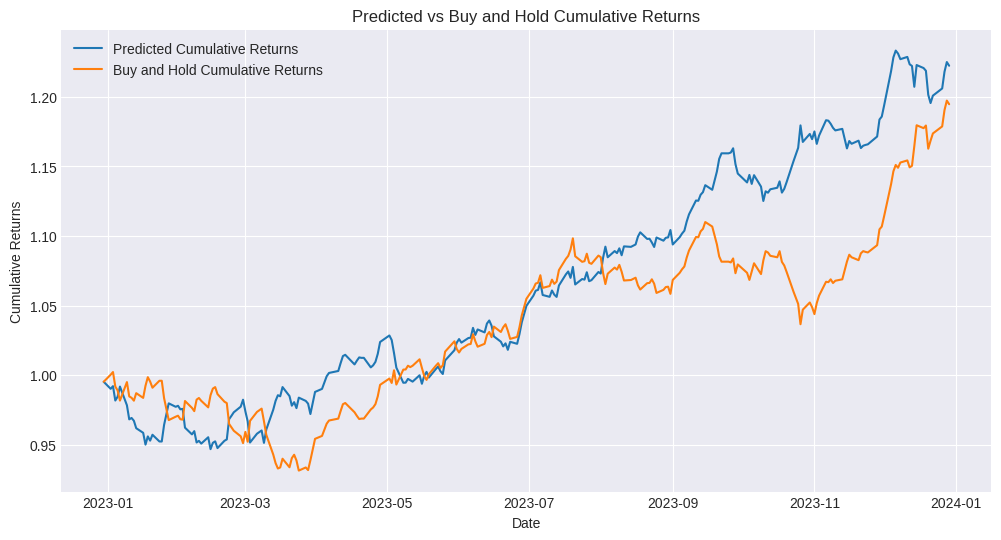

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(data_test['cumulative_returns'], label='Predicted Cumulative Returns')
plt.plot(buy_and_hold_returns, label='Buy and Hold Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Predicted vs Buy and Hold Cumulative Returns')
plt.legend()
plt.show()


The maximum drawdown of the strategy is -5.31


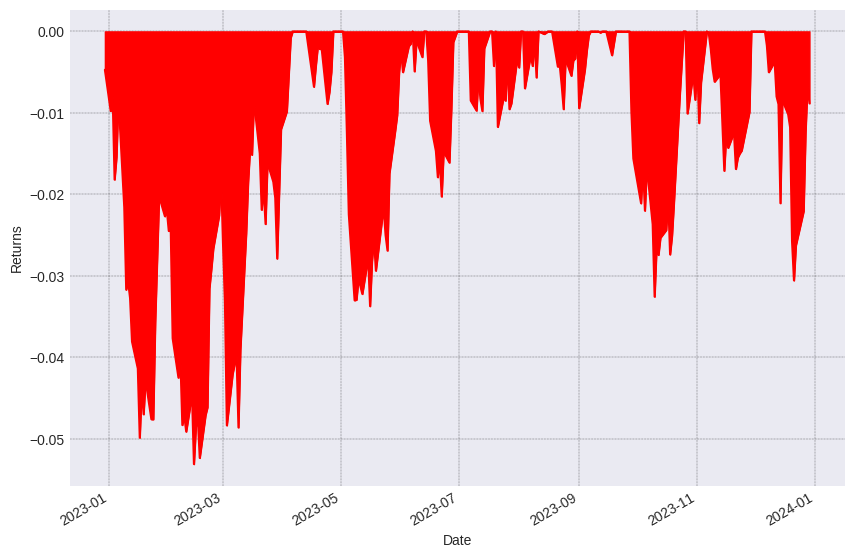

In [29]:
#DRAWDOWN ANALYSIS
def calc_drawdown(cum_rets):
# Calculate the running maximum
  running_max = np.maximum.accumulate(cum_rets.dropna())
  # Ensure the value never drops below 1
  running_max[running_max < 1] = 1
# Calculate the percentage drawdown
  drawdown = (cum_rets)/running_max - 1
  return drawdown
def plot_drawdown(drawdown):

  fig = plt.figure(figsize=(10, 7))
# Plot
  drawdown.plot(color='r')
  plt.ylabel('Returns')
  plt.fill_between(drawdown.index, drawdown, color='red')
  plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
  plt.show()
drawdown_strategy = calc_drawdown(data_test['cumulative_returns'])
print("The maximum drawdown of the strategy is %.2f" %(drawdown_strategy.min()*100))
plot_drawdown(drawdown_strategy)


The maximum drawdown of the bnh strategy is -7.06


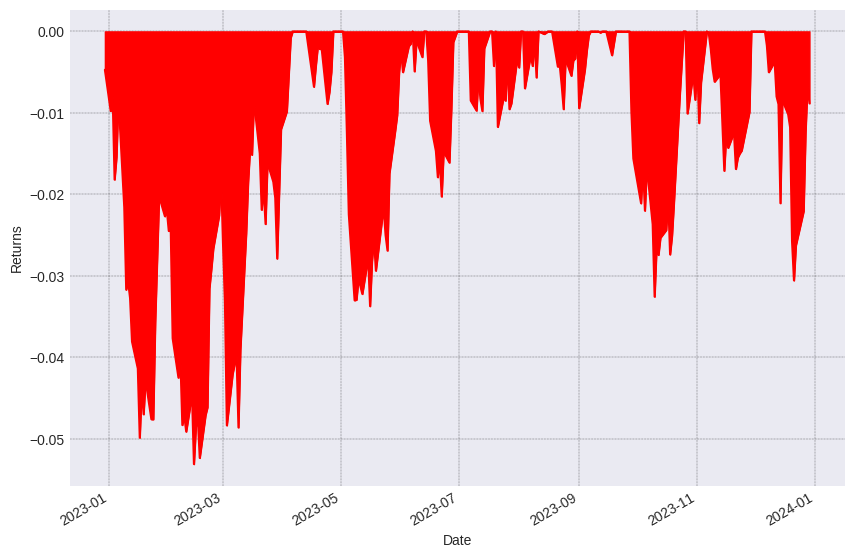

In [30]:
#buy and hold max drawdown

drawdown_buy_n_hold = calc_drawdown(buy_and_hold_returns)
print("The maximum drawdown of the bnh strategy is %.2f" % (drawdown_buy_n_hold.min()*100))
plot_drawdown(drawdown_strategy)


In [32]:
#let's check the sharpe ratio of the strategy
sharpe_ratio = (data_test['strategy_returns'].mean()*252)/(data_test['strategy_returns'].std()*np.sqrt(252))
print("The sharpe ratio of the strategy is %.2f" % sharpe_ratio)


The sharpe ratio of the strategy is 2.15
